In [1]:
import numpy 
import os
import ast
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

#from wquantiles import quantile
from openfisca_survey_manager.utils import asof

#from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
#from openfisca_france_indirect_taxation.surveys import SurveyScenario
#from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
#from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile

from openfisca_france_indirect_taxation.examples.utils_example import df_weighted_average_grouped
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities)
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Graph_utils import (
    graph_CO2_emissions,
    graph_delta_CO2,
    graph_winners_losers,
    graph_net_transfers,
    graph_effort_rate,
    quantiles_for_boxplot,
    boxplot_effort_rate,
    boxplot_net_transfers
    )

In [2]:
data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
output_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Output"
elasticite = True
replique_gouv = True
sns.set_style("whitegrid")

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
elasticites_douenne = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [4]:
to_graph, menages_reform, df_sum = simulate_reformes_energie(elas_vect = False, elasticites= elasticites_douenne, year = 2019, reform= carbon_tax_rv, bonus_cheques_uc = True)

In [5]:
to_graph

,niveau_vie_decile,Is_losers,Effort_rate,Net_transfers_reform,emissions_CO2_carburants_carbon_tax_rv,emissions_CO2_carburants,Reduction_CO2,ref_elasticity
0,1,0.164366,0.165953,12.356521,1428.282679,1453.368796,-1.726067,Douenne (2020)
1,2,0.283967,0.087968,10.620258,1695.509214,1723.708730,-1.635979,Douenne (2020)
2,3,0.304399,0.083997,5.612047,2011.681154,2045.017319,-1.630117,Douenne (2020)
3,4,0.375658,0.086519,0.624274,2389.579880,2429.709077,-1.651605,Douenne (2020)
4,5,0.380103,0.080886,-0.292543,2525.460554,2566.459966,-1.597508,Douenne (2020)
5,6,0.373607,0.076886,-3.157758,2714.763933,2759.859521,-1.633981,Douenne (2020)
6,7,0.406821,0.075024,-5.245573,3005.667252,3054.439471,-1.596765,Douenne (2020)
7,8,0.427155,0.066507,-5.920068,2975.410985,3024.952997,-1.637778,Douenne (2020)
8,9,0.438161,0.058764,-7.775310,3140.398895,3192.429051,-1.629798,Douenne (2020)
9,10,0.406359,0.039925,-6.838556,3091.171705,3141.722438,-1.609013,Douenne (2020)


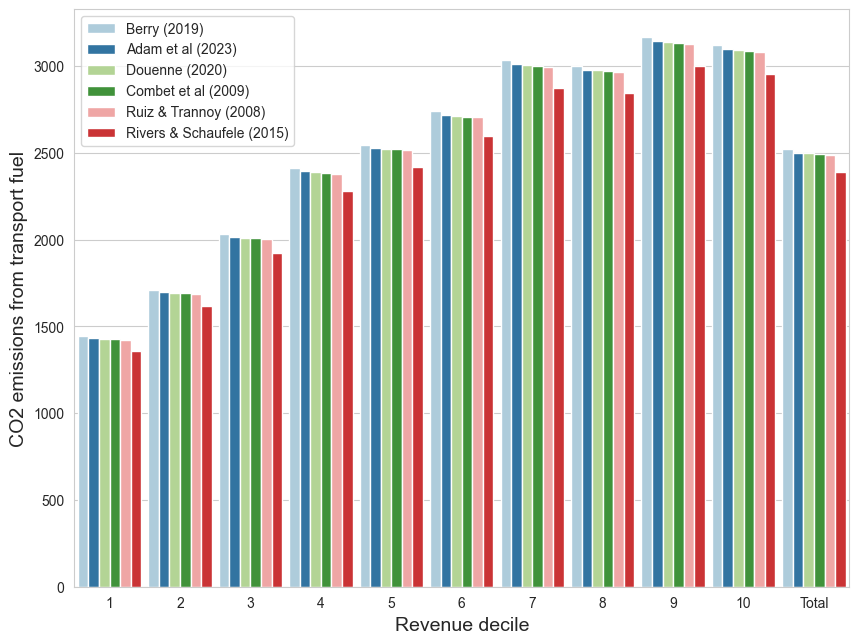

In [8]:
hue_order = ['Berry (2019)', 'Adam et al (2023)', 'Douenne (2020)', 'Combet et al (2009)', 'Ruiz & Trannoy (2008)','Rivers & Schaufele (2015)']
fig, ax = plt.subplots(figsize=(10, 7.5)) 
sns.barplot(x="niveau_vie_decile", y = 'emissions_CO2_carburants_carbon_tax_rv', data = to_graph, hue = 'ref_elasticity', hue_order = hue_order , palette = sns.color_palette("Paired"), width = .9)
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 14})
plt.ylabel('CO2 emissions from transport fuel', fontdict = {'fontsize' : 14})
plt.legend()

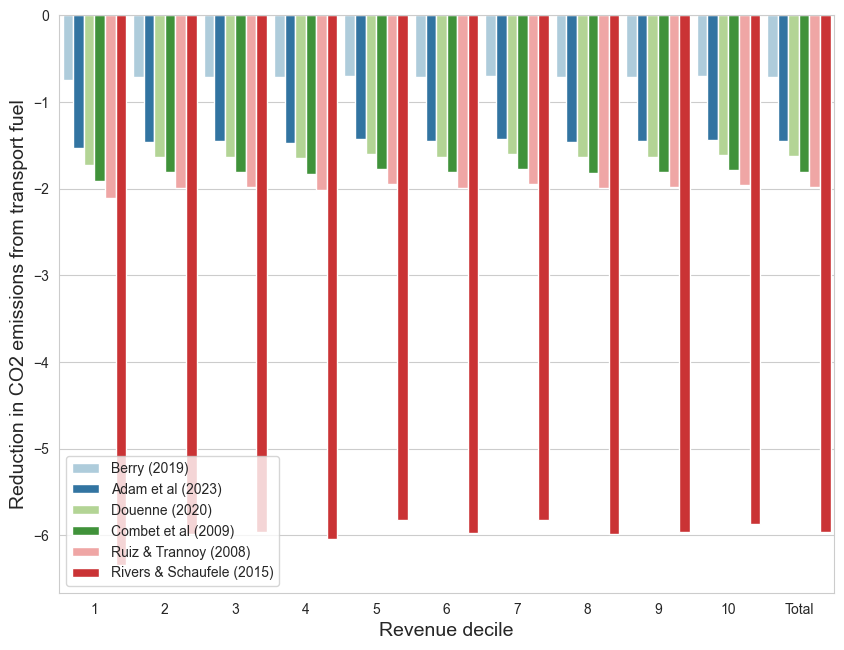

In [9]:
hue_order = ['Berry (2019)', 'Adam et al (2023)', 'Douenne (2020)', 'Combet et al (2009)', 'Ruiz & Trannoy (2008)','Rivers & Schaufele (2015)']
fig, ax = plt.subplots(figsize=(10, 7.5)) 
sns.barplot(x="niveau_vie_decile", y = 'Reduction_CO2', data = to_graph, hue = 'ref_elasticity', hue_order = hue_order , palette = sns.color_palette("Paired"), width = .9)
plt.xlabel('Revenue decile', fontdict = {'fontsize' : 14})
plt.ylabel('Reduction in CO2 emissions from transport fuel', fontdict = {'fontsize' : 14})
plt.legend()

In [30]:
def collapse_sum(dataframe, groupe, var):
    '''
    Pour une variable, fonction qui calcule la somme pondérée au sein de chaque groupe.
    '''
    grouped = dataframe.groupby([groupe])
    var_weighted_grouped = grouped.apply(lambda x: wsum(groupe = x, var = var))
    return var_weighted_grouped

def wsum(groupe, var):
    '''
    Fonction qui calcule la somme pondérée par groupe d'une variable
    '''
    d = groupe[var]
    w = groupe['pondmen']
    return (d * w).sum()

def df_weighted_sum_grouped(dataframe, groupe, varlist):
    '''
    Agrège les résultats de weighted_average_grouped() en une unique dataframe pour la liste de variable 'varlist'.
    '''
    return pd.DataFrame(
        dict([
            (var, collapse_sum(dataframe, groupe, var)) for var in varlist
            ])
        )

In [28]:
var_to_graph = list(menages_reform.columns)
var_to_graph.remove('ref_elasticity')
by_decile = df_weighted_sum_grouped(menages_reform,'niveau_vie_decile',var_to_graph)
by_decile.reindex(columns=['bonus_cheques_energie_uc','bonus_cheques_energie_menage', 'contributions_reforme','ticpe_totale','ticpe_totale_carbon_tax_rv','rev_disponible','pondmen','ocde10'])

In [37]:
df_sum.drop('pondmen', axis = 1, inplace = True)
df_sum.reindex(columns=['bonus_cheques_energie_uc','bonus_cheques_energie_menage', 'contributions_reforme','ticpe_totale','ticpe_totale_carbon_tax_rv','rev_disponible']).head(10)

In [4]:
to_graph, menages_reform = run_all_elasticities(df_elasticities, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
menages_reform.to_csv(os.path.join(output_path,'Data/menages_reform.csv'))
to_graph.to_csv(os.path.join(output_path,'Data/to_graph.csv'))

In [5]:
menages_reform = pd.read_csv(os.path.join(output_path,'Data/menages_reform.csv'), index_col = 0)
to_graph = pd.read_csv(os.path.join(output_path,'Data/to_graph.csv'), index_col = 0)

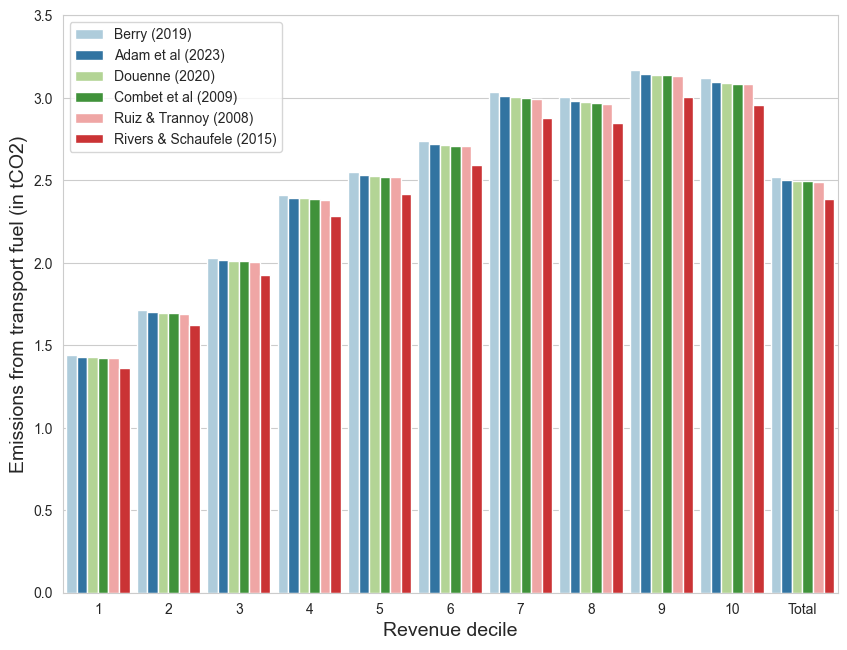

In [6]:
graph_CO2_emissions(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

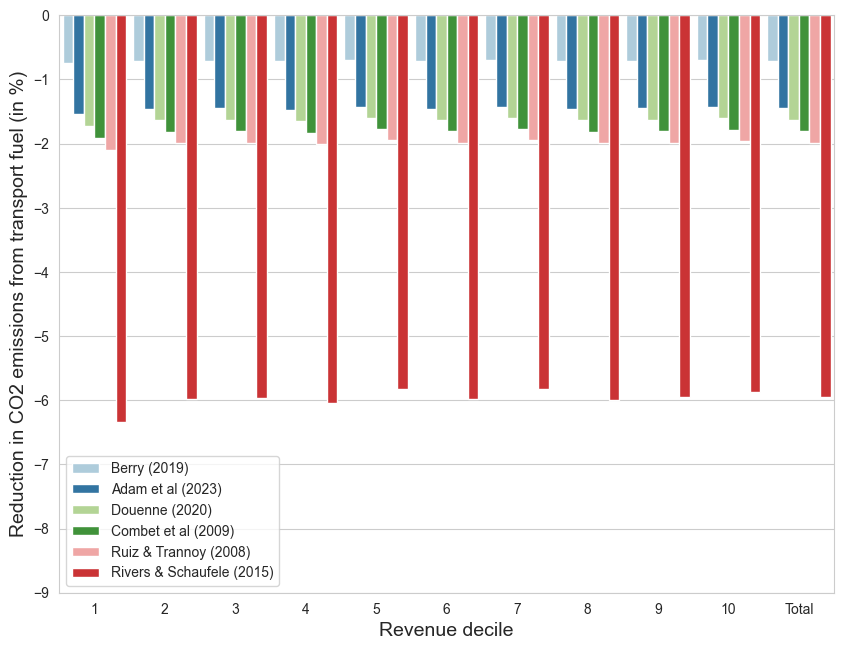

In [7]:
graph_delta_CO2(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

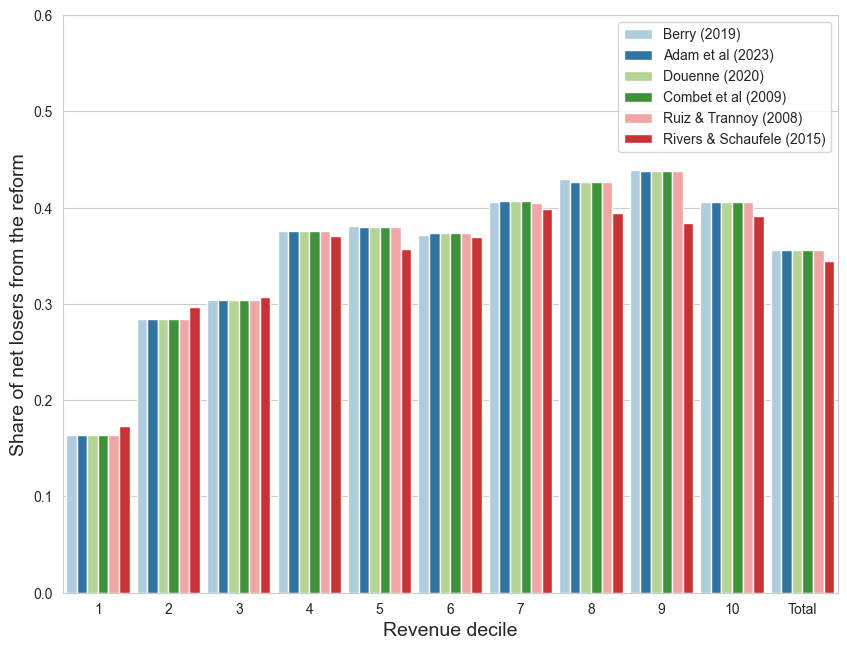

In [5]:
graph_winners_losers(to_graph,carbon_tax_rv,elas_vect= False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:132: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot , x='plot_decile', y='Net_transfers_reform', hue = 'ref_elasticity',


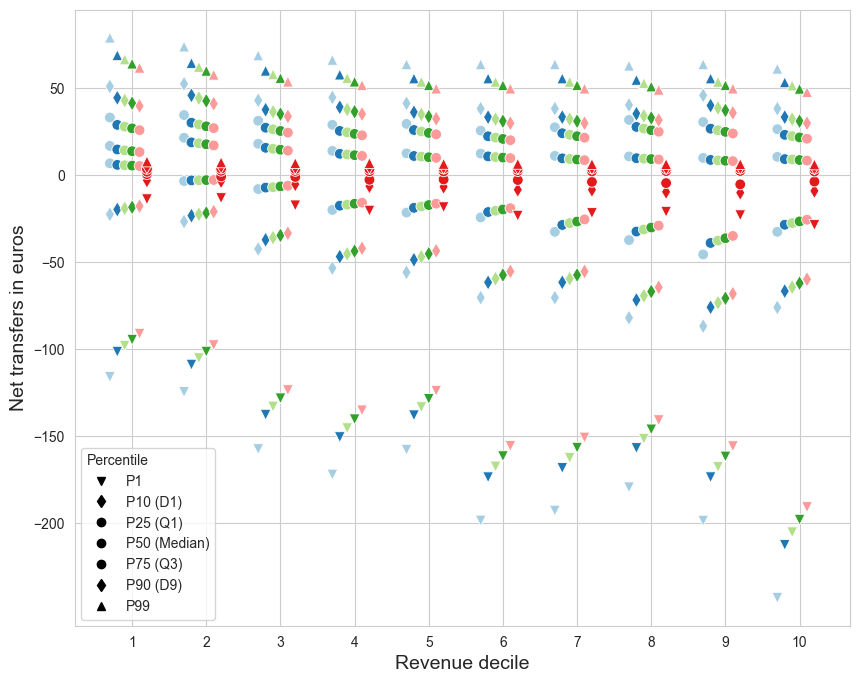

In [4]:
boxplot_net_transfers(menages_reform,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=True)

In [ ]:
quantile_net_transfers = quantiles_for_boxplot(menages_reform,'Net_transfers_reform')
quantile_net_transfers[quantile_net_transfers['quantile'] == 0.25].sort_values(by='niveau_vie_decile')

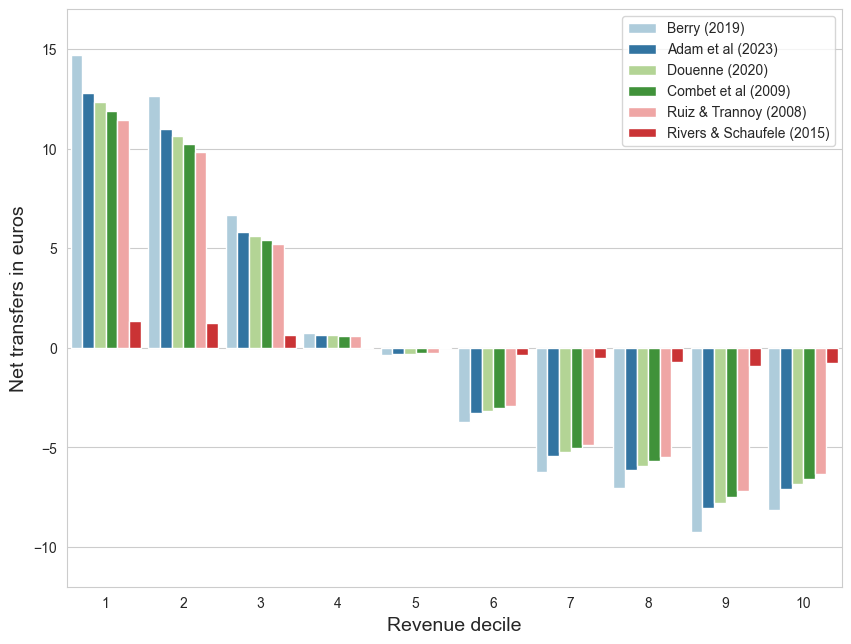

In [8]:
graph_net_transfers(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

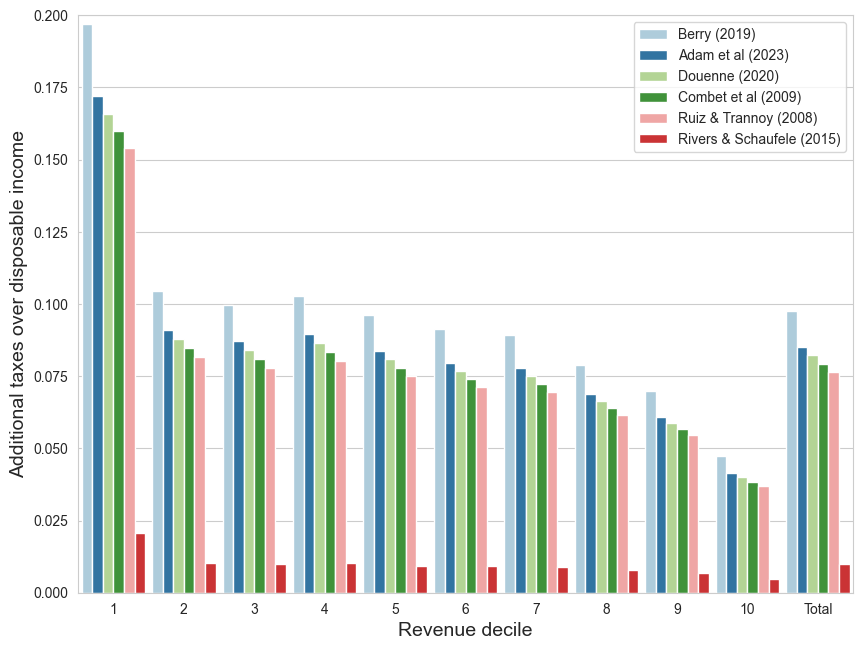

In [4]:
graph_effort_rate(to_graph,carbon_tax_rv,elas_vect = False,bonus_cheques_uc=True)

c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Graph_utils.py:160: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.scatterplot(data = quantiles_to_plot, x='plot_decile', y='Effort_rate', hue = 'ref_elasticity',


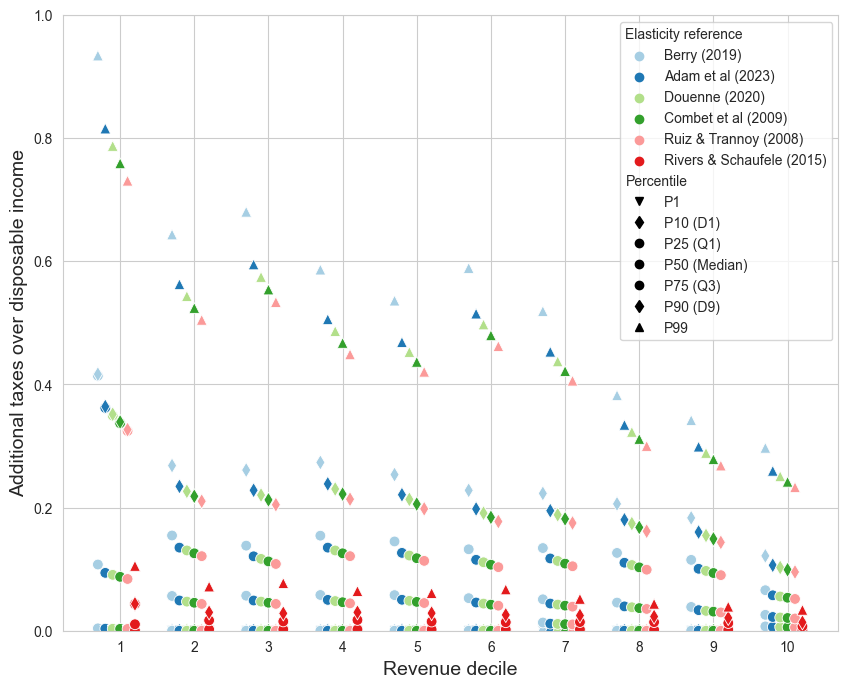

In [4]:
boxplot_effort_rate(menages_reform,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=True)

In [7]:
quantile_effort_rate = quantiles_for_boxplot(menages_reform,'Effort_rate')
quantile_effort_rate[quantile_effort_rate['quantile'] == 0.75].sort_values(by='niveau_vie_decile')

,niveau_vie_decile,ref_elasticity,Effort_rate,plot_decile,quantile,Percentile
0,1.0,Berry (2019),0.413929,0.7,0.75,P75 (Q3)
0,1.0,Combet et al (2009),0.336746,1.0,0.75,P75 (Q3)
0,1.0,Ruiz & Trannoy (2008),0.324297,1.1,0.75,P75 (Q3)
0,1.0,Rivers & Schaufele (2015),0.043352,1.2,0.75,P75 (Q3)
0,1.0,Adam et al (2023),0.361644,0.8,0.75,P75 (Q3)
0,1.0,Douenne (2020),0.349195,0.9,0.75,P75 (Q3)
0,2.0,Ruiz & Trannoy (2008),0.121049,2.1,0.75,P75 (Q3)
0,2.0,Douenne (2020),0.130284,1.9,0.75,P75 (Q3)
0,2.0,Adam et al (2023),0.134901,1.8,0.75,P75 (Q3)
0,2.0,Combet et al (2009),0.125666,2.0,0.75,P75 (Q3)


In [8]:
df_elas_vect = pd.read_csv(os.path.join(data_path,'Reform_parameters/Elasticities_Douenne_20.csv'), index_col = [0])
df_elas_vect = pd.melt(frame = df_elas_vect , id_vars = ["niveau_vie_decile",'ref_elasticity'], var_name = 'strate_2', value_name = 'elas_price_1_1')

In [10]:
to_graph_douenne_scal, menages_reform_douenne_scal = simulate_reformes_energie(elas_vect = True, elasticites = df_elas_vect, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_vect, menages_reform_douenne_vect = simulate_reformes_energie(elas_vect = False, elasticites = elasticites_douenne, year = 2019, reform = carbon_tax_rv,bonus_cheques_uc=True)
to_graph_douenne_only = pd.concat([to_graph_douenne_scal, to_graph_douenne_vect])
menages_reform_douenne_only = pd.concat([menages_reform_douenne_scal, menages_reform_douenne_vect])

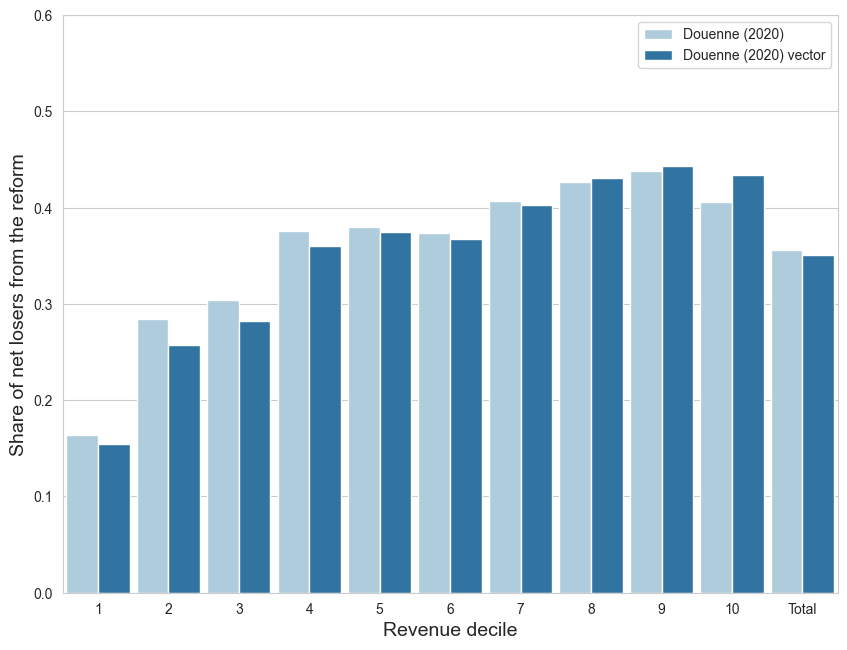

In [18]:
graph_winners_losers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

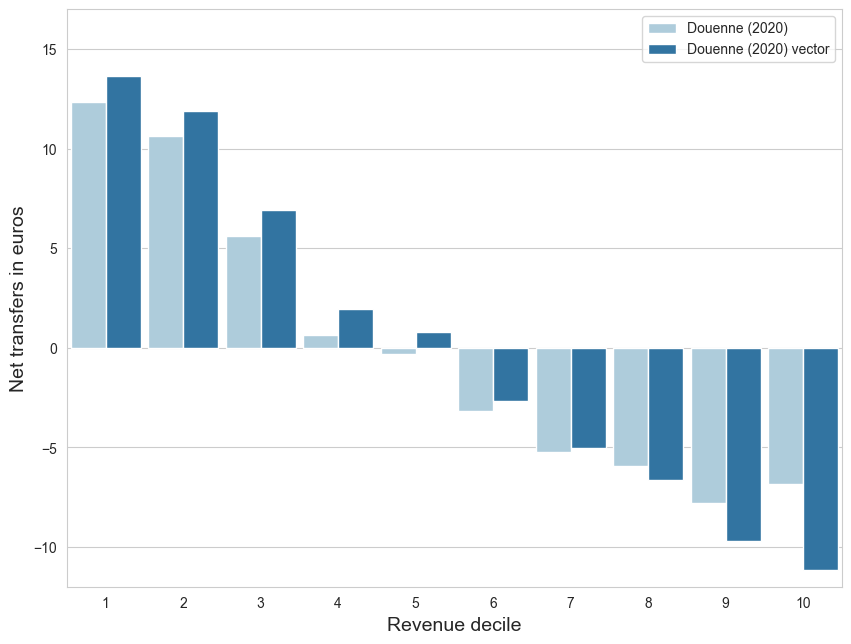

In [19]:
graph_net_transfers(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

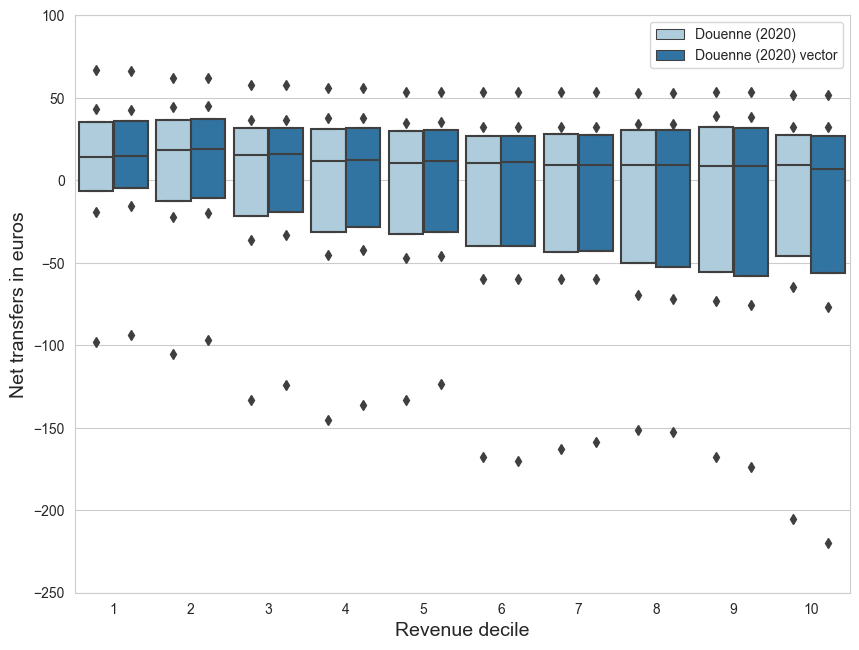

In [11]:
boxplot_net_transfers(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

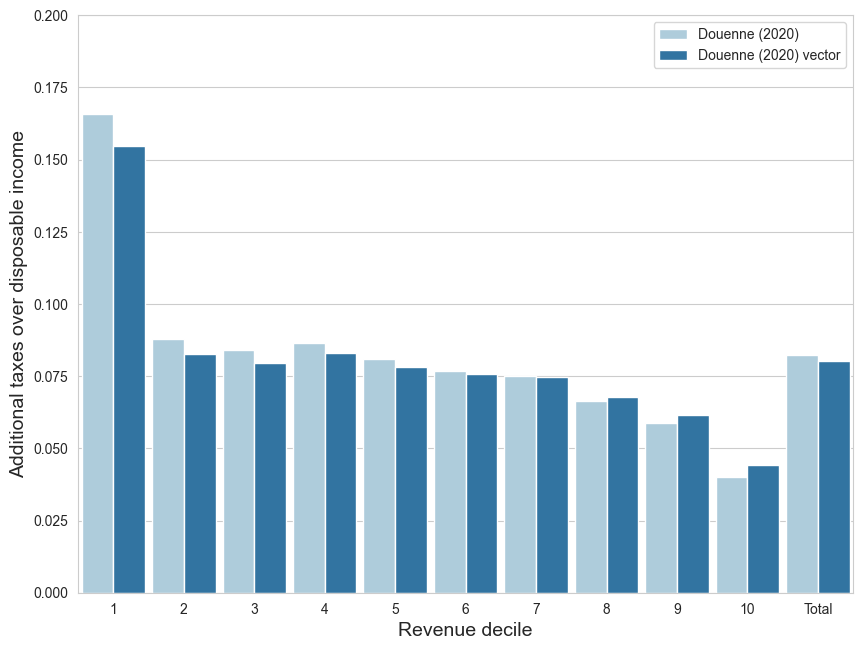

In [21]:
graph_effort_rate(to_graph_douenne_only,carbon_tax_rv,elas_vect=True,bonus_cheques_uc=True)

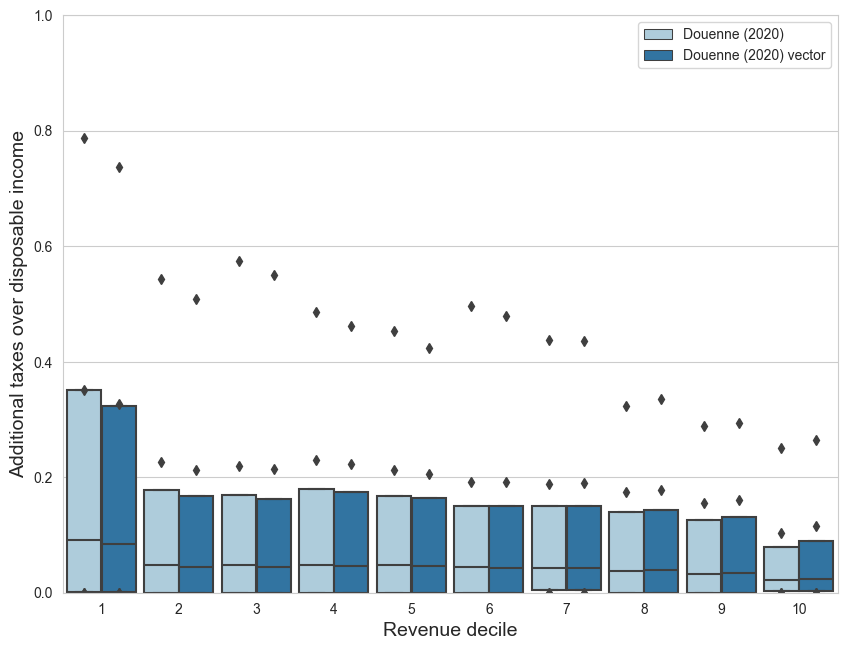

In [12]:
boxplot_effort_rate(menages_reform_douenne_only, carbon_tax_rv, elas_vect=True, bonus_cheques_uc=True)

In [13]:
to_graph_menage, menages_reform_menage = run_all_elasticities(data_elasticities = df_elasticities, year = 2019, reform = carbon_tax_rv, bonus_cheques_uc= False)

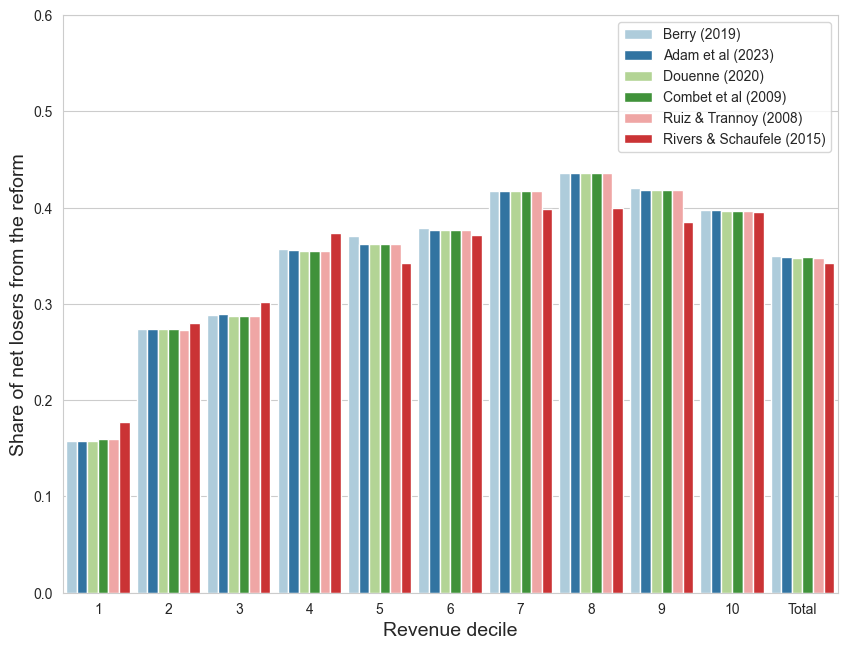

In [24]:
graph_winners_losers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

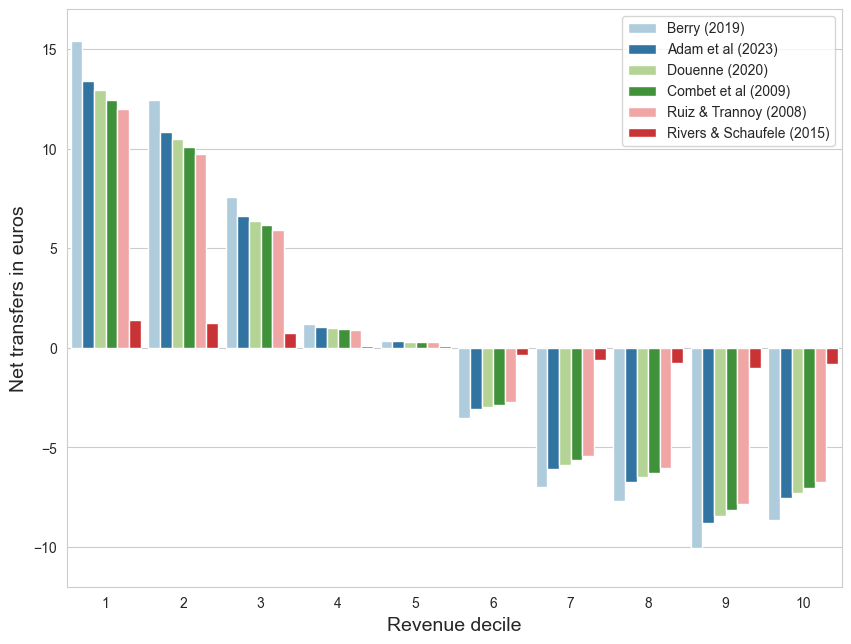

In [25]:
graph_net_transfers(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

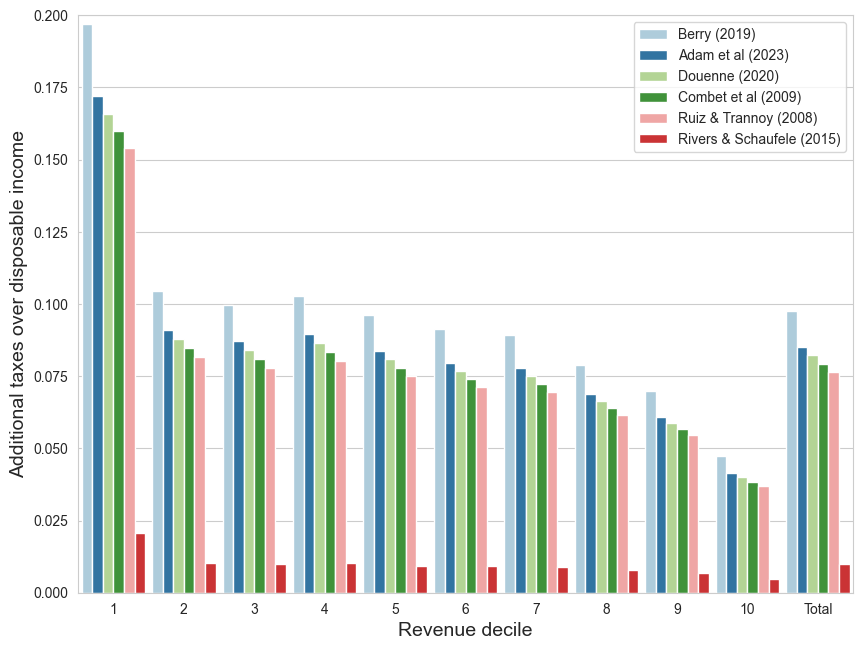

In [26]:
graph_effort_rate(to_graph_menage,carbon_tax_rv,elas_vect=False,bonus_cheques_uc=False)

## A creuser !

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

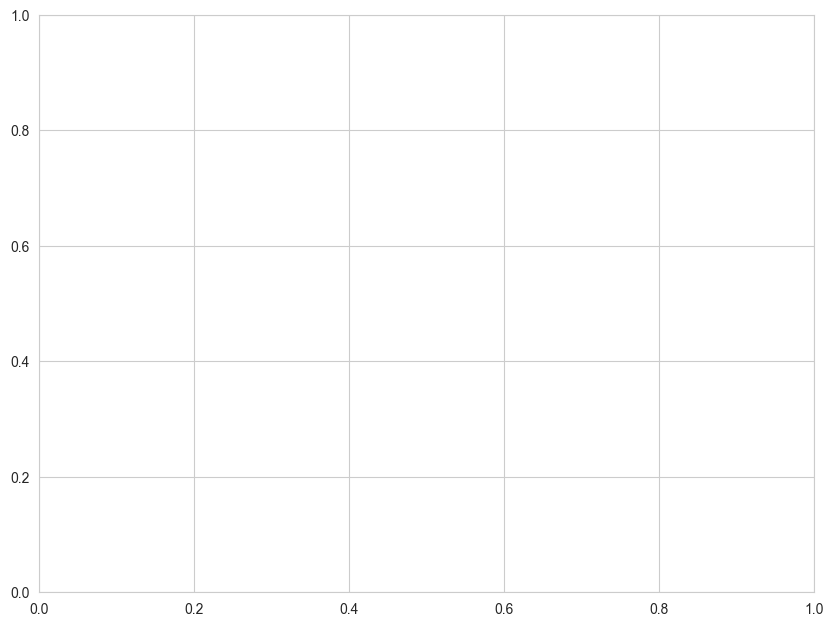

In [27]:
boxplot_net_transfers(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\veve1\AppData\Local\Temp\ipykernel_19344\3670938973.py", line 1, in <module>
    boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 223, in boxplot_effort_rate
  File "c:\users\veve1\onedrive\documents\ensae 3a\memoire mie\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\Master_Thesis_Herve\Simulation_taxe_energie_winners_losers.py", line 196, in quantiles_for_boxplot
    for q in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]:
  File "c:\Users\veve1\OneDrive\D

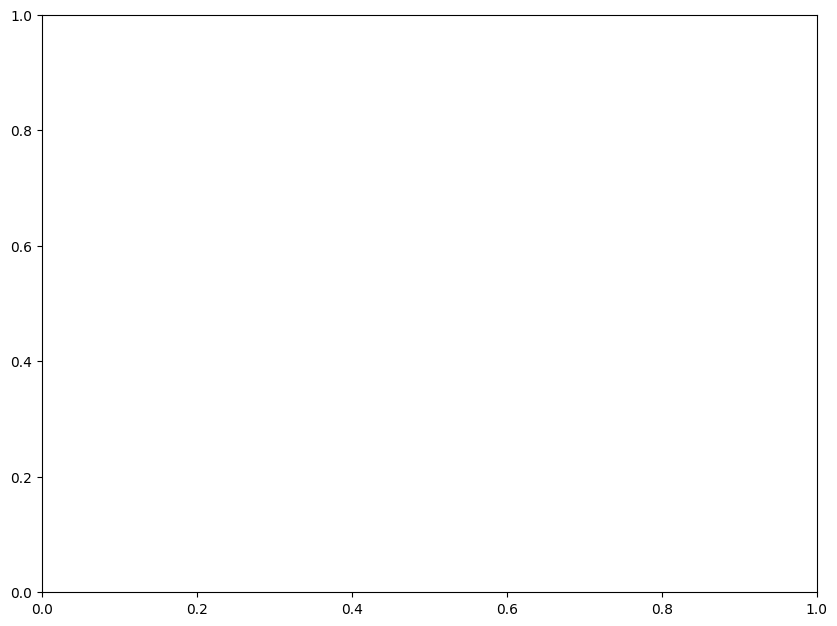

In [ ]:
boxplot_effort_rate(menages_reform_menage, carbon_tax_rv, elas_vect=False, bonus_cheques_uc=False)